# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim_dataset_HD.ipynb`


## Organization of the Notebook

- Read and Prepare dataset with human samples
- Application of different pre-treatments (including BinSim) to this dataset
- Add dataset to database of datasets
- Create persistance storage of data including the latest dataset
- Analyse dataset characteristics

#### Needed Imports

In [1]:
import itertools
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**.

Each data set is **represented as a dict**.

Each record has the following fields (keys):

- `name`: name of the data set (see below the list of data sets)
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix, the original data before any pre-treatments
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `Ionly`: missing value imputation by 1/2 min, only
    - `P`: Pareto scaled data, after missing value imputation
    - `NP`: Missing value imputed, Pareto scaled and normalized
    - `NGP`: Missing value imputed, normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys (and respective names) of datasets used in this study:

- GD_neg_global2 (GDg2-)
- GD_pos_global2 (GDg2+)
- GD_neg_class2 (GDc2-)
- GD_pos_class2 (GDc2+)
- YD (YD 2/15)
- YD2 (YD 6/15)
- vitis_types (GD types)
- HD (HD) **Added here**

### Description of the Human dataset

Human Dataset - 249 samples belonging to 2 different classes of HILIC-MS data obtained in positive ionization mode. The Chromatography system was a Thermo Dionex Ultimate 3000 with the column being a Waters Xbridge BEH HILIC (75 x 2.1mm, 2.5um). Mass Spectrometry was performed in a Thermo Q Exactive HF hybrid Orbitrap operating in positive electrospray ionization mode. Further information in the data deposition site mentioned below.

The 2 classes are:

- 135 pre-operative blood (serum) samples from patients with **'No Recurrence'** of Prostate Cancer after Radical Prostatectomy
- 114 pre-operative blood (serum) samples from patients with **'Recurrence'** of Prostate Cancer after Radical Prostatectomy

I think this means samples were collected before the Prostatectomy before knowledge of recurrence or no recurrence? There was a total of 80 subjects.

Data taken from data deposition site: https://www.metabolomicsworkbench.org/data/DRCCMetadata.php?Mode=Study&DataMode=AllData&StudyID=ST001082&StudyType=MS&ResultType=5#DataTabs

This data is available at the NIH Common Fund's National Metabolomics Data Repository (NMDR) website, the Metabolomics Workbench, https://www.metabolomicsworkbench.org where it has been assigned Project ID PR000724. The data can be accessed directly via it's Project DOI: 10.21228/M83D5V. 

Data deposited by the Georgia Institute of Technology and researcher Facundo Fernandez. This data was taken already aligned in a 2D numerical data matrix. 

Data used in the paper: Clendinen CS, Gaul DA, Monge ME, et al. Preoperative Metabolic Signatures of Prostate Cancer Recurrence Following Radical  Prostatectomy. J Proteome Res. 2019;18(3):1316-1327. doi:10.1021/acs.jproteome.8b00926

Dataset named **HD (HDg2-)** was generated after retaining only features that occur (globally) at least twice in all samples of the dataset. For the purpose of assessing the performance of supervised methods this dataset was used with target labels defining classes based on which of the 2 classes mentioned prior, the samples belonged to.


The data read from the site seemed to be completely untreated, which was perfect for our efforts. We can't be sure but the presence of plenty of missing values (very useful for us) points to no great peak filtering and missing value imputation being made, the bar plot built from adding up all intensities of each sample seems to point that no normalization had yet been employed in the data, and the distribution observed in the boxplot of the intensities of some of the features in the samples seems to point that no scaling had been used yet in the data as well.

The data also had 2 copies of each sample, where the 2nd copies were equal to the first ones multiplied by a constant. This constant was different for each sample. We removed the presence of the 2nd copies.


#### Loading Human dataset

In [3]:
# Reading the dataset, this dataset has two copies of the samples.The 2nd copy is equal to the 1st multiplied by a constant
# unique to each sample.
human_datamatrix_base = pd.read_excel('ST001082_AN001766_498recurrence.xlsx')

In [4]:
human_datamatrix = human_datamatrix_base.iloc[:-1, :-4] # Just select the rows corresponding to the dataset

human_datamatrix = human_datamatrix.set_index(human_datamatrix.columns[0]) # Set index as the metabolites name
human_datamatrix = human_datamatrix.replace({0:np.nan}) # Replacing 0 values as missing values

human_datamatrix

,2_Pooled_Sample_1,2_Pooled_Sample_1_2,P2_2,P2_3,P2_4,Psp_1,Psp_2,Psp_3,Psp_4,Psp_5,...,S67_3.1,S70_1.1,S70_2.1,S70_3.1,S72_1.1,S72_2.1,S72_3.1,S77_1.1,S77_2.1,S77_3.1
metabolite_name,,,,,,,,,,,,,,,,,,,,,
Factors,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,Sample Type:Pooled,...,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence,Sample Type:No Recurrence
95.06024579_7.857483333,2544.256904,2174.683995,2349.405324,2142.906787,2633.130278,2510.239989,3619.82127,2217.770816,2894.966994,20587.0328,...,4121.029059,3834.23691,4090.323428,3830.272712,3705.545567,3954.147516,3740.035077,3837.308267,4164.971893,4155.190276
71.06031304_0.064166667,153.7382834,2972.450721,951.0420238,2861.700714,3339.380877,299.8124672,783.1155979,3034.247021,3511.131943,NaN,...,8012.257751,853.7856117,6297.664545,7257.02521,845.5966076,6130.01575,7499.72554,796.3862056,5999.547509,7583.908921
71.06031992_9.984466667,292.2381888,1598.405492,638.9111168,1659.297423,1855.933656,382.0675008,948.3162562,1707.100565,1981.102653,62862.60997,...,4440.820011,662.2607137,3347.680062,4147.143726,694.8464783,3388.086581,4194.416655,650.7198089,3381.510189,4134.43322
126.1023924_4.038416667,347.8838312,125.0657553,260.8042864,119.6837125,NaN,803.1992227,NaN,126.2802051,0.001242692,582.9410185,...,322.3904954,4488.12769,3755.93028,1616.363518,1806.669855,1365.45848,495.4602756,1993.623747,1663.073748,1059.509693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588.4147684_2.0983,12264.30083,1935.998098,2697.901871,1761.340872,369.0957455,12243.27287,574.4747938,221.0599403,11.37397281,NaN,...,NaN,6225.892205,NaN,NaN,8491.983882,NaN,NaN,9425.946784,358.953733,NaN
177.1270579_2.0983,4477.875444,317.9191822,2573.952315,69.97337036,NaN,5703.699795,NaN,477.9239747,960.7144488,NaN,...,5104.451502,NaN,248.6690155,4012.400432,189.415007,1938.392231,5601.351328,NaN,25.42248559,4329.675354
374.2064688_2.0983,7056.085863,112.7816239,4444.488636,NaN,NaN,6690.765635,NaN,462.1335736,572.3140362,NaN,...,6158.786604,NaN,NaN,3297.509597,NaN,NaN,2256.379266,NaN,NaN,7587.036926


In [5]:
# Select one of the two copies of samples in the dataset by removing the samples ending with '.1'
human_datamatrix = human_datamatrix[[i for i in human_datamatrix.columns if not i.endswith('.1')]]

human_datamatrix = human_datamatrix.T # Transpose the dataset

In [6]:
# Current sample labels. Sample will consist of 'Sample Type:No Recurrence' and 'Sample Type:Recurrence'
hd_labels = list(human_datamatrix['Factors'])
set(hd_labels)

{'Sample Type:Blank',
 'Sample Type:No Recurrence',
 'Sample Type:Pooled',
 'Sample Type:Recurrence'}

In [7]:
# How many 'No Recurrence' samples in the dataset
hd_labels.count('Sample Type:No Recurrence')

135

In [8]:
human_datamatrix

metabolite_name,Factors,95.06024579_7.857483333,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
2_Pooled_Sample_1,Sample Type:Pooled,2544.256904,153.7382834,292.2381888,347.8838312,10893.35227,NaN,1019.575684,4961.683983,16245.18195,...,667.2516344,NaN,9295.784827,1.857344785,434.1598764,12264.30083,4477.875444,7056.085863,531.2204529,7176.296988
2_Pooled_Sample_1_2,Sample Type:Pooled,2174.683995,2972.450721,1598.405492,125.0657553,16141.38879,4.46641878,974.3024286,7183.313463,11147.94187,...,NaN,NaN,2947.227078,NaN,NaN,1935.998098,317.9191822,112.7816239,NaN,103.1776278
P2_2,Sample Type:Pooled,2349.405324,951.0420238,638.9111168,260.8042864,11237.46827,NaN,1041.732062,5740.060295,11996.71846,...,NaN,9.956258609,2838.994292,NaN,10.14789037,2697.901871,2573.952315,4444.488636,NaN,5587.177152
P2_3,Sample Type:Pooled,2142.906787,2861.700714,1659.297423,119.6837125,16211.28236,NaN,882.8069733,6012.871319,8190.90361,...,NaN,9.098016406,2764.350408,NaN,NaN,1761.340872,69.97337036,NaN,NaN,11.30429951
P2_4,Sample Type:Pooled,2633.130278,3339.380877,1855.933656,NaN,27391.41899,NaN,545.7780635,2927.423375,1104.565641,...,NaN,NaN,609.5261629,NaN,NaN,369.0957455,NaN,NaN,NaN,6.817855612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,Sample Type:No Recurrence,4042.390453,6266.816562,3463.69699,1395.930804,10517.7526,97.700184,17988.63512,4597.778125,24216.15305,...,7049.366359,NaN,0.910517997,1273.048903,3601.773523,NaN,1981.650461,NaN,3938.848802,144.146236
S72_3,Sample Type:No Recurrence,3860.581052,7741.451008,4329.607912,511.4295756,15224.61293,594.5983793,9768.49416,7663.919663,17897.95381,...,5875.548618,NaN,0.355728465,NaN,15046.7641,NaN,5781.889838,2329.105172,4675.475887,1257.137318
S77_1,Sample Type:No Recurrence,4741.732906,984.0884324,804.0895638,2463.50584,5199.447492,8.686503713,10287.69548,2550.038217,36939.60819,...,NaN,2098.000087,3969.01007,NaN,81.4497374,11647.5714,NaN,NaN,0.896501216,239.696676
S77_2,Sample Type:No Recurrence,4153.731532,5983.356024,3372.384222,1658.585471,7551.248853,26.64915706,8092.077171,4522.858963,32505.31818,...,NaN,349.8420486,782.9663571,NaN,486.1349482,357.9849943,25.35387578,NaN,NaN,351.8411172


### Blank Treatment

- If blank_treatment = True:

An average of the blanks will be subtracted to the remaining dataset. Missing values in the blanks were replaced by 0 to calculate the average of the blanks. Negative values that arise in the dataset from subtracting the blanks will be coded as 0/missing values in the dataset. With the BinSim pre-treatment, they will be coded as 0.

Possible problem for BinSim: features that are very similar between samples might be slightly negative in one and be coded as 0 and slightly positive in the other and be coded as 1, despite being basically identical.

- If blank_treatment = False:

Blank samples are removed and not accounted for. 

In [9]:
blank_treatment = True
#blank_treatment = False

In [10]:
if blank_treatment:
    blanks = human_datamatrix[human_datamatrix['Factors'] == 'Sample Type:Blank'].iloc[:,1:] # Select blank samples
    blanks = blanks.replace({np.nan:0}) 
    blanks = blanks.astype(float) # Get blank samples with floats (needed since datamatrix has strings)
    blanks_average = blanks.mean() # Average of the blanks
    blanks_average

In [11]:
# Selecting the samples belonging to either the 'No Recurrence' or 'Recurrence' 
selection = []
for i in human_datamatrix.loc[:, 'Factors']:
    if i in ['Sample Type:No Recurrence', 'Sample Type:Recurrence']:
        selection.append(True)
    else:
        selection.append(False)

In [12]:
human_datamatrix = human_datamatrix[selection]
# Creating the list of 'targets' (labels of samples) of the dataset with the 'No Recurrence' and 'Recurrence' classes 
hd_labels = []
for i in list(human_datamatrix.iloc[:,0]):
    if i == 'Sample Type:No Recurrence':
        hd_labels.append('No Recurrence')
    else:
        hd_labels.append('Recurrence')

In [13]:
human_datamatrix = human_datamatrix.iloc[:,1:]
human_datamatrix

metabolite_name,95.06024579_7.857483333,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,88.05051567_0.095966667,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,5839.689646,2421.207099,1702.403305,1732.645968,11202.3156,13.77354446,15969.09873,11122.92882,76033.09098,15559.66213,...,549.5061406,1788.00406,237.4614192,3065.766426,170.0414581,1347.054595,479.0767276,NaN,NaN,41.58211389
S10_2,4925.936713,6760.239327,3927.481184,876.2460627,16464.75568,144.7380541,11235.281,17168.89308,50955.48348,17634.72493,...,2354.284435,428.9492324,6.856593556,126.8752621,6686.085356,NaN,5663.904982,11572.89831,1720.669345,3969.969384
S10_3,5530.737291,11234.04531,6138.510579,302.5141329,24441.42344,196.744245,6281.973729,23329.82436,38668.17711,17924.91677,...,1187.542997,8.16828659,4.535420845,NaN,6985.148407,5.695198924,5001.930045,9622.04692,1835.400914,3534.540622
S15_1,4345.962212,1647.020375,1087.357218,2044.425809,4820.244022,8.539063852,10824.9497,2858.654761,48787.91979,12293.8573,...,NaN,2378.896459,578.7754145,NaN,155.6123097,2164.462213,936.4502838,NaN,NaN,66.89873449
S15_2,4135.848719,7164.394072,3594.221384,1396.827349,6507.869956,56.61978795,8963.260007,6670.576787,49360.26082,23406.46182,...,NaN,437.5625196,11.89033556,1.767176652,1485.254178,73.86922602,1952.194542,NaN,NaN,282.3818514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,4042.390453,6266.816562,3463.69699,1395.930804,10517.7526,97.700184,17988.63512,4597.778125,24216.15305,23606.86636,...,7049.366359,NaN,0.910517997,1273.048903,3601.773523,NaN,1981.650461,NaN,3938.848802,144.146236
S72_3,3860.581052,7741.451008,4329.607912,511.4295756,15224.61293,594.5983793,9768.49416,7663.919663,17897.95381,12847.39403,...,5875.548618,NaN,0.355728465,NaN,15046.7641,NaN,5781.889838,2329.105172,4675.475887,1257.137318
S77_1,4741.732906,984.0884324,804.0895638,2463.50584,5199.447492,8.686503713,10287.69548,2550.038217,36939.60819,17136.32435,...,NaN,2098.000087,3969.01007,NaN,81.4497374,11647.5714,NaN,NaN,0.896501216,239.696676
S77_2,4153.731532,5983.356024,3372.384222,1658.585471,7551.248853,26.64915706,8092.077171,4522.858963,32505.31818,23193.57557,...,NaN,349.8420486,782.9663571,NaN,486.1349482,357.9849943,25.35387578,NaN,NaN,351.8411172


In [14]:
human_datamatrix = human_datamatrix.astype(float) # Passing the values from strings to floats.

In [15]:
if blank_treatment:
    human_datamatrix = human_datamatrix.replace({np.nan:0}) - blanks_average
    human_datamatrix[human_datamatrix<0] = 0
    human_datamatrix = human_datamatrix.replace({0:np.nan})

In [16]:
human_datamatrix = transf.keep_atleast(human_datamatrix, minimum=2) # Keep features that appear in at least two samples
human_datamatrix

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,NaN,NaN,767.728678,7664.437238,NaN,11885.760381,11034.772529,71411.834905,NaN,272.371357,...,549.506141,1788.004060,237.461419,3065.766426,170.041458,1347.054595,474.490232,NaN,NaN,41.582114
S10_2,NaN,NaN,NaN,12926.877318,128.638686,7151.942651,17080.736789,46334.227405,881.713011,470.898334,...,2354.284435,428.949232,6.856594,126.875262,6686.085356,NaN,5659.318486,11569.699041,1720.669345,3969.969384
S10_3,1546.96215,0.29663,NaN,20903.545078,180.644877,2198.635380,23241.668069,34046.921035,1439.412175,101.298661,...,1187.542997,8.168287,4.535421,NaN,6985.148407,5.695199,4997.343549,9618.847651,1835.400914,3534.540622
S15_1,NaN,NaN,1079.508519,1282.365660,NaN,6741.611351,2770.498470,44166.663715,155.791159,NaN,...,NaN,2378.896459,578.775415,NaN,155.612310,2164.462213,931.863788,NaN,NaN,66.898734
S15_2,NaN,NaN,431.910059,2969.991594,40.520419,4879.921658,6582.420496,44739.004745,168.413145,NaN,...,NaN,437.562520,11.890336,1.767177,1485.254178,73.869226,1947.608046,NaN,NaN,282.381851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,NaN,NaN,431.013514,6979.874238,81.600816,13905.296771,4509.621834,19594.896975,33.998957,NaN,...,7049.366359,NaN,0.910518,1273.048903,3601.773523,NaN,1977.063965,NaN,3938.848802,144.146236
S72_3,NaN,NaN,NaN,11686.734568,578.499011,5685.155811,7575.763372,13276.697735,901.326825,NaN,...,5875.548618,NaN,0.355728,NaN,15046.764100,NaN,5777.303342,2325.905903,4675.475887,1257.137318
S77_1,NaN,NaN,1498.588550,1661.569130,NaN,6204.357131,2461.881926,32318.352115,NaN,NaN,...,NaN,2098.000087,3969.010070,NaN,81.449737,11647.571400,NaN,NaN,0.896501,239.696676
S77_2,NaN,NaN,693.668181,4013.370491,10.549789,4008.738822,4434.702672,27884.062105,164.837670,NaN,...,NaN,349.842049,782.966357,NaN,486.134948,357.984994,20.767380,NaN,NaN,351.841117


In [17]:
#human_datamatrix.replace({np.nan:1}).select_dtypes(exclude=["float", 'int'])

### Building human dataset with format of the dataset database

In [18]:
datasets = {}

# HD (HDg2-)
datasets['HD'] = {'source': 'human',
                  'alignment': '1-2',
                  'mode': '-',
                  'name': 'HD',
                  'data': human_datamatrix,
                  'target': hd_labels,
                  'classes': list(pd.unique(hd_labels))}

print('target for human 2-class dataset')
print(datasets['HD']['target'])

target for human 2-class dataset
['Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 'Recurrence', 

In [19]:
datasets['HD']['data']

metabolite_name,71.06031304_0.064166667,71.06031992_9.984466667,126.1023924_4.038416667,121.0717995_1.358816667,105.0697004_2.574533333,83.06023778_3.971433333,85.02828928_2.7925,85.0282975_2.440233333,103.0539927_2.632416667,117.0695881_0.77655,...,370.0920791_2.0983,468.1567372_2.0983,727.5149425_2.0983,497.1417674_2.0983,400.1388094_2.0983,588.4147684_2.0983,177.1270579_2.0983,374.2064688_2.0983,211.0531259_2.0983,206.0808246_2.0983
S10_1,NaN,NaN,767.728678,7664.437238,NaN,11885.760381,11034.772529,71411.834905,NaN,272.371357,...,549.506141,1788.004060,237.461419,3065.766426,170.041458,1347.054595,474.490232,NaN,NaN,41.582114
S10_2,NaN,NaN,NaN,12926.877318,128.638686,7151.942651,17080.736789,46334.227405,881.713011,470.898334,...,2354.284435,428.949232,6.856594,126.875262,6686.085356,NaN,5659.318486,11569.699041,1720.669345,3969.969384
S10_3,1546.96215,0.29663,NaN,20903.545078,180.644877,2198.635380,23241.668069,34046.921035,1439.412175,101.298661,...,1187.542997,8.168287,4.535421,NaN,6985.148407,5.695199,4997.343549,9618.847651,1835.400914,3534.540622
S15_1,NaN,NaN,1079.508519,1282.365660,NaN,6741.611351,2770.498470,44166.663715,155.791159,NaN,...,NaN,2378.896459,578.775415,NaN,155.612310,2164.462213,931.863788,NaN,NaN,66.898734
S15_2,NaN,NaN,431.910059,2969.991594,40.520419,4879.921658,6582.420496,44739.004745,168.413145,NaN,...,NaN,437.562520,11.890336,1.767177,1485.254178,73.869226,1947.608046,NaN,NaN,282.381851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S72_2,NaN,NaN,431.013514,6979.874238,81.600816,13905.296771,4509.621834,19594.896975,33.998957,NaN,...,7049.366359,NaN,0.910518,1273.048903,3601.773523,NaN,1977.063965,NaN,3938.848802,144.146236
S72_3,NaN,NaN,NaN,11686.734568,578.499011,5685.155811,7575.763372,13276.697735,901.326825,NaN,...,5875.548618,NaN,0.355728,NaN,15046.764100,NaN,5777.303342,2325.905903,4675.475887,1257.137318
S77_1,NaN,NaN,1498.588550,1661.569130,NaN,6204.357131,2461.881926,32318.352115,NaN,NaN,...,NaN,2098.000087,3969.010070,NaN,81.449737,11647.571400,NaN,NaN,0.896501,239.696676
S77_2,NaN,NaN,693.668181,4013.370491,10.549789,4008.738822,4434.702672,27884.062105,164.837670,NaN,...,NaN,349.842049,782.966357,NaN,486.134948,357.984994,20.767380,NaN,NaN,351.841117


### Plots comparing the sum of all peaks between samples and between-feature variation

#### Comparing Total Intensity of Features (Sum)

In [20]:
total_sum_feat = datasets['HD']['data'].sum(axis=1)

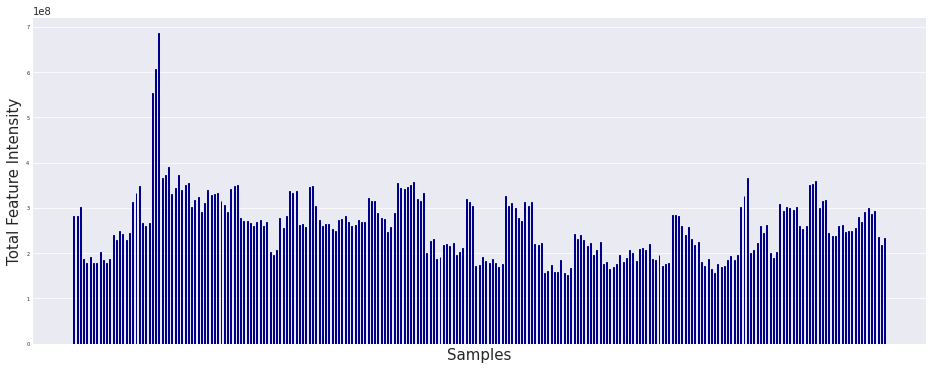

In [21]:
with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(figsize=(16,6))
    
    values = list(total_sum_feat)
    x = np.arange(len(datasets['HD']['target']))  # the label locations
    width = 0.30  # the width of the bars

    ax.bar(x, values, width, ec='darkblue')
    ax.set_xticks(x)
    ax.set_ylabel('Total Feature Intensity', fontsize = 15)
    ax.set_xlabel('Samples', fontsize = 15)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.get_xaxis().set_ticks([])
    

#### Comparing Intensity in Features with a boxplot

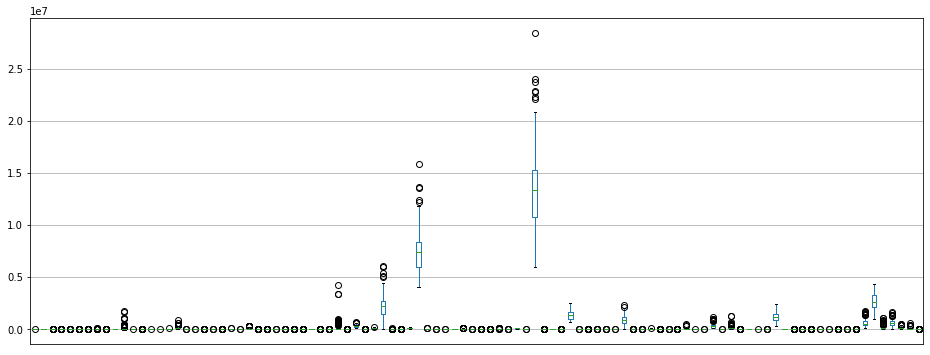

In [22]:
fig, ax = plt.subplots(figsize=(16,6))
box_p = datasets['HD']['data'].iloc[:,:100].boxplot(ax=ax)
ax.get_xaxis().set_ticks([])
plt.show()

### Colors for plots to ensure consistency

#### 2 HD classes

In [23]:
# customize label colors for 2 HD classes

colours = sns.color_palette('Set1', 5)
hd_label_colors = {lbl: c for lbl, c in zip(datasets['HD']['classes'], colours)}
datasets['HD']['label_colors'] = hd_label_colors
datasets['HD']['sample_colors'] = [hd_label_colors[lbl] for lbl in datasets['HD']['target']]

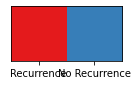

In [24]:
sns.palplot(hd_label_colors.values())
new_ticks = plt.xticks(range(len(datasets['HD']['classes'])), datasets['HD']['classes'])

Samples and respective target labels of each dataset

In [25]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [26]:
parsed = mtl.parse_data(datasets['HD']['data'])
y = datasets['HD']['target']
label_colors = datasets['HD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,S10_1,S10_2,S10_3,S15_1,S15_2,S15_3,S25_1,S25_2,S25_3,S34_1,S34_2,S34_3,S35_1,S35_2,S35_3,S37_1,S37_2,S37_3,S39_1,S39_2,S39_3,S45_1,S45_2,S45_3,S48_1,S48_2,S48_3,S49_1,S49_2,S49_3,S50_1,S50_2,S50_3,S51_1,S51_2,S51_3,S52_1,S52_2,S52_3,S53_1,S53_2,S53_3,S54_1,S54_2,S54_3,S57_1,S57_2,S57_3,S58_1,S58_2,S58_3,S59_1,S59_2,S59_3,S60_1,S60_2,S60_3,S61_1,S61_2,S61_3,S62_1,S62_2,S62_3,S63_1,S63_2,S63_3,S64_1,S64_2,S64_3,S65_1,S65_2,S65_3,S68_1,S68_2,S68_3,S69A_1,S69A_2,S69A_3,S69B_1,S69B_2,S69B_3,S71_1,S71_2,S71_3,S73_1,S73_2,S73_3,S74_1,S74_2,S74_3,S75_1,S75_2,S75_3,S76_1,S76_2,S76_3,S78_1,S78_2,S78_3,S79_1,S79_2,S79_3,S80_1,S80_2,S80_3,S81_1,S81_2,S81_3,S82_1,S82_2,S82_3,S83_1,S83_2,S83_3,S1_1,S1_2,S1_3,S2_1,S2_2,S2_3,S3_1,S3_2,S3_3,S4_1,S4_2,S4_3,S5_1,S5_2,S5_3,S6_1,S6_2,S6_3,S8_1,S8_2,S8_3,S9_1,S9_2,S9_3,S11_1,S11_2,S11_3,S12_1,S12_2,S12_3,S13A_1,S13A_2,S13A_3,S13B_1,S13B_2,S13B_3,S14_1,S14_2,S14_3,S16_1,S16_2,S16_3,S17_1,S17_2,S17_3,S18_1,S18_2,S18_3,S19_1,S19_2,S19_3,S20A_1,S20A_2,S20A_3,S20B_1,S20B_2,S20B_3,S21_1,S21_2,S21_3,S22_1,S22_2,S22_3,S23_1,S23_2,S23_3,S24_1,S24_2,S24_3,S26_1,S26_2,S26_3,S27_1,S27_2,S27_3,S28_1,S28_2,S28_3,S29_1,S29_2,S29_3,S30_1,S30_2,S30_3,S31_1,S31_2,S31_3,S32_1,S32_2,S32_3,S33_1,S33_2,S33_3,S36_1,S36_2,S36_3,S38_1,S38_2,S38_3,S41_1,S41_2,S41_3,S42_1,S42_2,S42_3,S43_1,S43_2,S43_3,S44_1,S44_2,S44_3,S46_1,S46_2,S46_3,S47_1,S47_2,S47_3,S66A_1,S66A_2,S66A_3,S66B_1,S66B_2,S66B_3,S67_1,S67_2,S67_3,S70_1,S70_2,S70_3,S72_1,S72_2,S72_3,S77_1,S77_2,S77_3
label,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recu

## Data transformations and pre-treatments

Each data set is transformed by Binary simplification and missing values are imputed by two different methods and then treated by three combinations of more established treatments (generating 7 datasets with different treatments applied).

### Traditional and more established  intensity-based Pre-Treatments

Missing value imputation is mandatory for the data sets since many statistical methods performed downstream can't handle missing values. 

Two missing value imputation procedures were applied before any intensity-based pre-treatments: 

- Missing values were replaced with half of the minimum intensity value present in the whole data matrix - Limit of Detection type of imputation commonly applied in metabolomics data analysis. This was performed with the `fillna_frac_min`function from metabolinks. 

- Missing values were imputed by Random Forest missing value imputation. Parameters: 10 trees, 100 nearest features considered, 0 minimum value, 1.0e10 maximum value and 2 max iterations, others were left as default. This was performed by using the scikit-learn Python module with `IterativeImputer`and `ExtraTreesRegressor` as estimator. In cases where this method was used, an extra **`_RF`** was added to the 'name' of the pre-treatment.

#### Combinations of intensity-based pre-treatments made:

- Ionly Treatment - Only Missing Value Imputation.

- **P Treatment** - Missing Value Imputation and Pareto Scaling.

- **NP Treatment** - Missing Value Imputation, Normalization by reference feature (Leucine Enkephalin) and Pareto Scaling.

- **NGP Treatment** - Missing Value Imputation, Normalization by reference feature (Leucine Enkephalin), Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak (reference feature) is removed upon normalization. Order of pre-treatments is the order in which they were mentioned.

### Binary Simplification (BinSim)

- **BinSim Treatment** - `df_to_bool` function

In [27]:
def impute_RF(df, nearest_features=100, n_trees=50):
    rf_estimator = ExtraTreesRegressor(n_estimators=n_trees)
    imputer = IterativeImputer(random_state=0, estimator=rf_estimator,
                           n_nearest_features=nearest_features,
                           min_value=0.0, max_value=1.0e10,
                           max_iter=2,
                           verbose=2)
    imputed_data = imputer.fit_transform(df)
    res = pd.DataFrame(imputed_data, index=df.index, columns=df.columns)
    ncols = len(res.columns)
    res = res.dropna(axis='columns', how='any')
    ncols2 = len(res.columns)
    if ncols > ncols2:
        print(f'{ncols-ncols2} features dropped')
    return res
    

In [28]:
# Represents Binary Simplification pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

# Performs all pre-treatment combinations mentioned
def compute_transf(dataset, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data']
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Imputation by RF
    imputedRF = impute_RF(data, nearest_features=100, n_trees=10)
    
    
    # Normalization by the total sum of peak areas
    #norm = transf.normalize_sum(imputed)
    #normRF = transf.normalize_sum(imputedRF)
    
    # Normalization by PQN
    norm = transf.normalize_PQN(imputed, ref_sample='mean')
    normRF = transf.normalize_PQN(imputedRF, ref_sample='mean')
    
    # Normalization by a reference feature RF
    #if norm_ref is not None:
    #    normRF = transf.normalize_ref_feature(imputedRF, norm_ref, remove=True)
    #else:
    #    normRF = imputedRF
        
    # Normalization by a reference feature
    #if norm_ref is not None:
    #    norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    #else:
    #    norm = imputed
    
    # Normalization by a reference feature RF
    #if norm_ref is not None:
    #    normRF = transf.normalize_ref_feature(imputedRF, norm_ref, remove=True)
    #else:
    #    normRF = imputedRF
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))

    # Pareto Scaling and Generalized Logarithmic Transformation
    P_RF = transf.pareto_scale(imputedRF)
    NP_RF = transf.pareto_scale(normRF)
    NGP_RF = transf.pareto_scale(transf.glog(normRF, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP
    
    dataset['Ionly_RF'] = imputedRF
    dataset['P_RF'] = P_RF
    dataset['NP_RF'] = NP_RF
    dataset['NGP_RF'] = NGP_RF    

##### Apply the different pre-treatments and get the results in their respective dictionaries

In [29]:
GENERATE = False

In [30]:
if GENERATE:
    for name, ds in datasets.items():
        dataset_name = datasets[name]["name"]
        print(f'Applying pre-processing transformations to data in {dataset_name}', end=' ...')
        start = perf_counter()

        compute_transf(ds)

        end = perf_counter()

        print(f'done! took {(end - start):.3f} s')
    
    hd_datasets = datasets
    # ensure dir exists
    path = Path.cwd() / "paperimages"
    path.mkdir(parents=True, exist_ok=True)

    storepath = Path.cwd() / "paperimages" / 'processed_data_HD.h5'

    store = pd.HDFStore(storepath, complevel=9, complib="blosc:blosclz")
    #pd.set_option('io.hdf.default_format','table')

    # keep json serializable values and store dataFrames in HDF store

    serializable = {}

    for dskey, dataset in datasets.items():
        if dskey != 'HD':
            continue
        serializable[dskey] = {}
        for key, value in dataset.items():
            #print(dskey, key)
            if isinstance(value, pd.DataFrame):
                storekey = dskey + '_' + key
                #print('-----', storekey)
                store[storekey] = value
                serializable[dskey][key] = f"INSTORE_{storekey}"
            else:
                serializable[dskey][key] = value
    store.close()
            

    path = path / 'processed_data_HD.json'
    with open(path, "w", encoding='utf8') as write_file:
        json.dump(serializable, write_file)

    #serializable

### Reading back the other benchmark datasets and adding HD to them

In [31]:
path = Path.cwd() / "paperimages" / 'processed_data.json'
storepath = Path.cwd() / "paperimages" / 'processed_data.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        for key in dataset:
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                dataset[key] = store[storekey]
            # transform colors, saved as lists in json, back into tuples
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]

In [32]:
if not GENERATE:

    path = Path.cwd() / "paperimages" / 'processed_data_HD.json'
    storepath = Path.cwd() / "paperimages" / 'processed_data_HD.h5'
    with pd.HDFStore(storepath) as store:

        with open(path, encoding='utf8') as read_file:
            hd_datasets = json.load(read_file)

        for dskey, dataset in hd_datasets.items():
            for key in dataset:
                value = dataset[key]
                if isinstance(value, str) and value.startswith("INSTORE"):
                    storekey = value.split("_", 1)[1]
                    dataset[key] = store[storekey]
                # transform colors, saved as lists in json, back into tuples
                elif key == 'label_colors':
                    dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
                elif key == 'sample_colors':
                    dataset[key] = [tuple(c) for c in value]

In [33]:
datasets['HD'] = hd_datasets['HD']

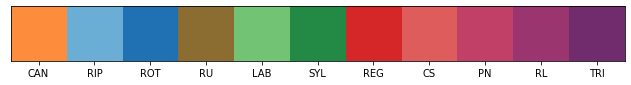

In [34]:
label_colors = datasets['GD_neg_class2']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

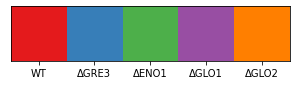

In [35]:
label_colors = datasets['YD']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

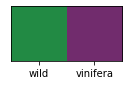

In [36]:
label_colors = datasets['vitis_types']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

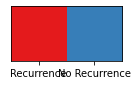

In [37]:
label_colors = datasets['HD']['label_colors']
sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(label_colors)), label_colors.keys())

In [38]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [39]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


In [40]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [41]:
parsed = mtl.parse_data(datasets['HD']['data'])
y = datasets['HD']['target']
label_colors = datasets['HD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,S10_1,S10_2,S10_3,S15_1,S15_2,S15_3,S25_1,S25_2,S25_3,S34_1,S34_2,S34_3,S35_1,S35_2,S35_3,S37_1,S37_2,S37_3,S39_1,S39_2,S39_3,S45_1,S45_2,S45_3,S48_1,S48_2,S48_3,S49_1,S49_2,S49_3,S50_1,S50_2,S50_3,S51_1,S51_2,S51_3,S52_1,S52_2,S52_3,S53_1,S53_2,S53_3,S54_1,S54_2,S54_3,S57_1,S57_2,S57_3,S58_1,S58_2,S58_3,S59_1,S59_2,S59_3,S60_1,S60_2,S60_3,S61_1,S61_2,S61_3,S62_1,S62_2,S62_3,S63_1,S63_2,S63_3,S64_1,S64_2,S64_3,S65_1,S65_2,S65_3,S68_1,S68_2,S68_3,S69A_1,S69A_2,S69A_3,S69B_1,S69B_2,S69B_3,S71_1,S71_2,S71_3,S73_1,S73_2,S73_3,S74_1,S74_2,S74_3,S75_1,S75_2,S75_3,S76_1,S76_2,S76_3,S78_1,S78_2,S78_3,S79_1,S79_2,S79_3,S80_1,S80_2,S80_3,S81_1,S81_2,S81_3,S82_1,S82_2,S82_3,S83_1,S83_2,S83_3,S1_1,S1_2,S1_3,S2_1,S2_2,S2_3,S3_1,S3_2,S3_3,S4_1,S4_2,S4_3,S5_1,S5_2,S5_3,S6_1,S6_2,S6_3,S8_1,S8_2,S8_3,S9_1,S9_2,S9_3,S11_1,S11_2,S11_3,S12_1,S12_2,S12_3,S13A_1,S13A_2,S13A_3,S13B_1,S13B_2,S13B_3,S14_1,S14_2,S14_3,S16_1,S16_2,S16_3,S17_1,S17_2,S17_3,S18_1,S18_2,S18_3,S19_1,S19_2,S19_3,S20A_1,S20A_2,S20A_3,S20B_1,S20B_2,S20B_3,S21_1,S21_2,S21_3,S22_1,S22_2,S22_3,S23_1,S23_2,S23_3,S24_1,S24_2,S24_3,S26_1,S26_2,S26_3,S27_1,S27_2,S27_3,S28_1,S28_2,S28_3,S29_1,S29_2,S29_3,S30_1,S30_2,S30_3,S31_1,S31_2,S31_3,S32_1,S32_2,S32_3,S33_1,S33_2,S33_3,S36_1,S36_2,S36_3,S38_1,S38_2,S38_3,S41_1,S41_2,S41_3,S42_1,S42_2,S42_3,S43_1,S43_2,S43_3,S44_1,S44_2,S44_3,S46_1,S46_2,S46_3,S47_1,S47_2,S47_3,S66A_1,S66A_2,S66A_3,S66B_1,S66B_2,S66B_3,S67_1,S67_2,S67_3,S70_1,S70_2,S70_3,S72_1,S72_2,S72_3,S77_1,S77_2,S77_3
label,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recurrence,No Recu

### Dataset Characteristics

Building a table with general characteristics about the 8 datasets studied.

In [42]:
def characterize_dataset(dskey, ds):
    "Computes and returns some general characteristics of a dataset in a dictionary."

    dataset_chrs = {}
    
    name = ds['name'] # Name of the dataset
    n_samples, n_feats = ds['data'].shape
    n_classes = len(ds['classes'])
       
    Feat_Sample = ds['data'].count(axis=1) # Nº Features in each sample
    Min_Feat_Sample = str(Feat_Sample.min()) # Minimum nº Features in a sample
    Max_Feat_Sample = str(Feat_Sample.max()) # Maximum nº Features in a sample
    Average_Feat_Sample = Feat_Sample.mean() # Average nº Features in a sample
    
    avg_feat_per_sample = int(round(Average_Feat_Sample,0)) # Round
    
    Samp_Class = len(ds['target'])/len(ds['classes']) # Nº Sample per Class
    if dskey == 'vitis_types':
        Samp_Class = '15 Vitis vinifera, 18 Wild'
        #Samp_Class = '15 $\it{Vitis}$ $\it{Vinifera}$, 18 Wild'
    elif dskey == 'HD':
        Samp_Class = '114 Recurrence, 135 no Recurrence'
    else:
        Samp_Class = str(int(Samp_Class))
    
    n_na = ds['data'].isna().sum().sum() # Nº of missing values in the dataset
    
    p_na = round(100.0 * n_na / (n_samples * n_feats), 2) # % of missing values in the dataset
    
    avg_na_per_feature = (n_samples - ds['data'].count(axis=0)).mean()
    avg_na_per_feature = int(round(avg_na_per_feature, 0))
    
    return {'Data set': name,
            '# samples': n_samples,
            '# features': n_feats,
            'features / sample (range)': f'{avg_feat_per_sample} ({Min_Feat_Sample}-{Max_Feat_Sample})',
            '# classes': n_classes,
            'samples / class':Samp_Class,
            '% missing values': p_na,} 
            #'missing values / feature': avg_na_per_feature}

data_characteristics = [characterize_dataset(dskey, ds) for dskey, ds in datasets.items()]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Data set')
data_characteristics

,# samples,# features,features / sample (range),# classes,samples / class,% missing values
Data set,,,,,,
GDg2-,33,3629,658 (367-1002),11,3,81.86
GDg2+,33,7026,1164 (355-2141),11,3,83.43
GDc2-,33,3026,547 (338-919),11,3,81.91
GDc2+,33,4565,824 (215-1670),11,3,81.94
YD 2/15,15,1973,685 (584-757),5,3,65.27
YD 6/15,15,606,468 (383-514),5,3,22.76
GD types,33,3026,547 (338-919),2,"15 Vitis vinifera, 18 Wild",81.91
HD,249,12869,7936 (7057-8475),2,"114 Recurrence, 135 no Recurrence",38.33


In [43]:
data_characteristics.to_excel('paperimages/dataset_characteristics.xlsx', index=True)

### PCA scores plots for the 8 datasets

Representation of the samples when projected in the 2 Principal Components obtained from PCA.

Preliminary assessment of the extent of class’s proximity, and consequent degree of difficulty for clustering and classification methods. Greater proximity/overlap would mean a more difficult task for the methods since it would mean the classes are similar to each other or less well defined.

Ellipses shown are 95% confidence ellipses for each class.

In [44]:
# To consider: Maybe remove this function? No longer used
def plot_PCA_old(principaldf, label_colors, label_symbols=None, components=(1,2), var_explained=None, title="PCA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #with sns.axes_style("whitegrid"):
    ax.axis('equal')
    if var_explained is not None:
        v1, v2 = var_explained[loc_c1], var_explained[loc_c2]
        ax.set_xlabel(f'{col_c1_name} ({100*v1:.1f}%)', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name} ({100*v2:.1f}%)', fontsize = 15)
    else:
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

    unique_labels = principaldf['Label'].unique()
    if label_symbols is None:
        label_symbols = {lbl: 'o' for lbl in unique_labels}

    lbl_handles = {}
    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        hndl = ax.scatter(subset[col_c1_name], subset[col_c2_name],
                          lw=1,ec='black', alpha=0.8,
                          marker=label_symbols[lbl], 
                          s=80, color=label_colors[lbl], label=lbl)
        lbl_handles[lbl] = hndl

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)
    return lbl_handles

def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot confidence ellipses of a class' samples based on their projection in the 2 main components of a PCA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


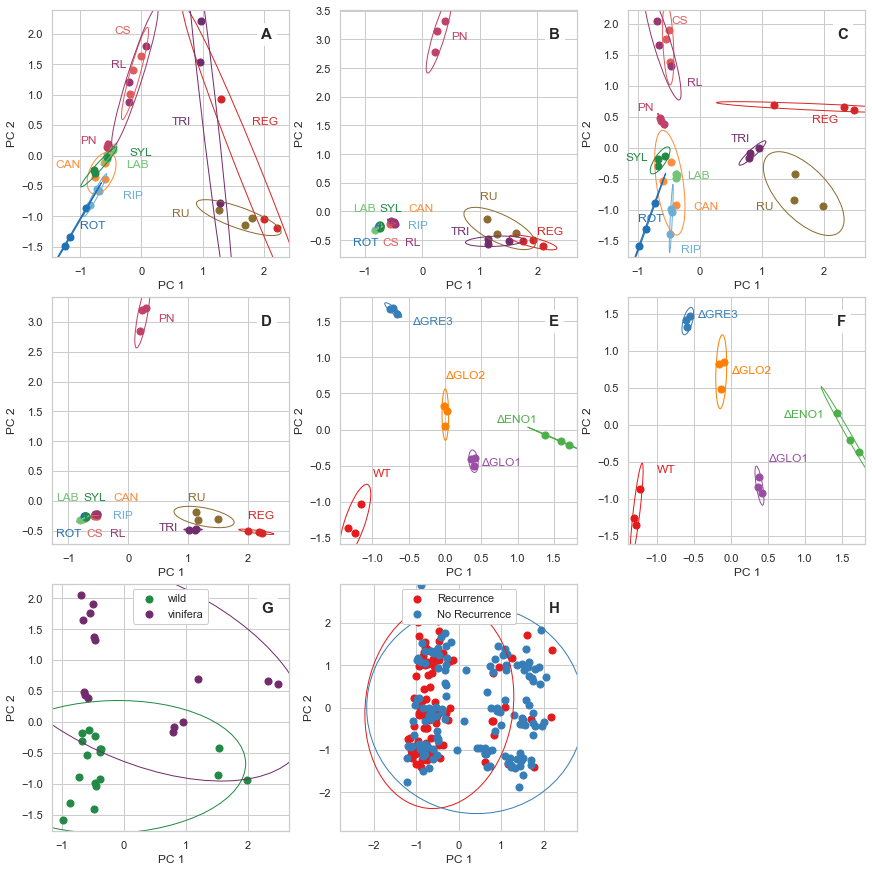

In [45]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)

        for (dskey, ds), ax in zip(datasets.items(), axs.ravel()):
            df = datasets[dskey]['Ionly']
            tf = transf.FeatureScaler(method='standard')
            df = tf.fit_transform(df)
            #print(df)
            ax.axis('equal')
            principaldf = ma.compute_df_with_PCs(df, n_components=5, whiten=True, labels=datasets[dskey]['target'], return_var_ratios=False)

            lcolors = datasets[dskey]['label_colors']
            #plot_PCA(principaldf, lcolors, components=(1,2), title=datasets[dskey]['name'], ax=ax)
            plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)

        #axs[2][1].remove()
        axs[2][2].remove()
        
        
        #axs[0][1].legend(loc='upper right', ncol=1)
        #axs[1][1].legend(loc='upper right', ncol=1)
        axs[2][0].legend(loc='upper center', ncol=1, framealpha=1)
        axs[2][1].legend(loc='upper center', ncol=1, framealpha=1)
        axs[2][1].set_xlim(-3, 3)
        axs[2][1].set_ylim(-2, 2)
        
        locs_YD = {'WT':(-1,-0.65),
                   'ΔGRE3':(-0.45, 1.45),
                   'ΔENO1':(0.7, 0.1),
                   'ΔGLO1':(0.5, -0.5),
                   'ΔGLO2':(0,0.7) }
        for lbl in datasets['YD']['classes']:
            axs[1][1].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])
        for lbl in datasets['YD']['classes']:
            axs[1][2].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])

        locs_GD = {'CAN':(-1.4,-0.2),
                       'CS':(-0.45, 2),
                       'LAB':(-0.25, -0.2),
                       'PN':(-1, 0.2),
                       'REG':(1.8,0.5),
                       'RIP':(-0.3,-0.7),
                       'RL':(-0.5, 1.45),
                       'ROT':(-1, -1.2),
                       'RU':(0.5, -1),
                       'SYL':(-0.2,0),
                       'TRI':(0.5,0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.1,-1),
                       'CS':(-0.45, 2),
                       'LAB':(-0.2, -0.5),
                       'PN':(-1, 0.6),
                       'REG':(1.8,0.4),
                       'RIP':(-0.3,-1.7),
                       'RL':(-0.2, 1),
                       'ROT':(-1, -1.2),
                       'RU':(0.9, -1),
                       'SYL':(-1.2,-0.2),
                       'TRI':(0.5,0.1),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][2].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.3),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[1][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.4),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0.2),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.4),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][1].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()[0:8]):
            ax.text(0.88, 0.9, letter, ha='left', va='center', fontsize=15, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.9))
        
        plt.show()
        #f.savefig('paperimages/PCAs.pdf', dpi=200)
        #f.savefig('paperimages/PCAs.png', dpi=600)


## Back to HD data only, to try the analysis

In [46]:
datasets = hd_datasets

### Unsupervised methods

In [47]:
def perform_HCA(df, metric='euclidean', method='average'):
    "Performs Hierarchical Clustering Analysis of a data set with chosen linkage method and distance metric."
    print(metric)
    
    distances = dist.pdist(df, metric=metric)
    print(np.all(np.isfinite(distances)))
    
    # method is one of
    # ward, average, centroid, single, complete, weighted, median
    Z = hier.linkage(distances, method=method)

    # Cophenetic Correlation Coefficient
    # (see how the clustering - from hier.linkage - preserves the original distances)
    coph = hier.cophenet(Z, distances)
    # Baker's gamma
    mr = ma.mergerank(Z)
    bg = mr[mr!=0]

    return {'Z': Z, 'distances': distances, 'coph': coph, 'merge_rank': mr, "Baker's Gamma": bg}

Dictionaries to contain results

In [48]:
HCA_all = {}

Perform the clusterings

In [49]:
for name, ds in datasets.items():
    HCA_all[name] = {}
    for treat in 'P', 'NP', 'NGP', 'BinSim', 'P_RF', 'NP_RF', 'NGP_RF':
        print(f'Performing HCA to {name} data set with treatment {treat}', end=' ...')
        metric = 'jaccard' if treat == 'BinSim' else 'euclidean'
        HCA_all[name][treat] = perform_HCA(datasets[name][treat], metric=metric, method='average')
        print('done!')

Performing HCA to HD data set with treatment P ...euclidean
True
done!
Performing HCA to HD data set with treatment NP ...euclidean
True
done!
Performing HCA to HD data set with treatment NGP ...euclidean
True
done!
Performing HCA to HD data set with treatment BinSim ...jaccard
True
done!
Performing HCA to HD data set with treatment P_RF ...euclidean
True
done!
Performing HCA to HD data set with treatment NP_RF ...euclidean
True
done!
Performing HCA to HD data set with treatment NGP_RF ...euclidean
True
done!


In [50]:
# alternative dendogram plots - Newer
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram2(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)

    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

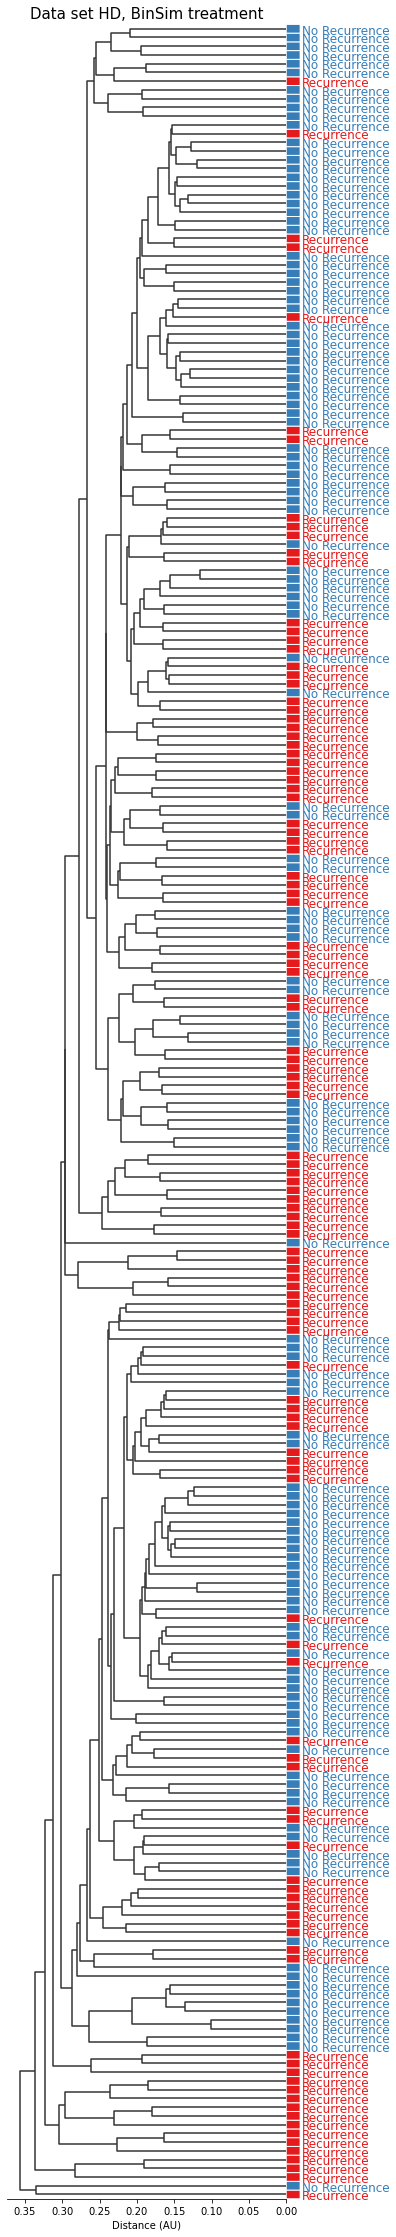

In [51]:
f, ax = plt.subplots(figsize=(5, 40))
name = 'HD'
title = f"Data set {datasets[name]['name']}, BinSim treatment"
plot_dendogram2(HCA_all[name]['BinSim']['Z'], 
               datasets[name]['target'], ax=ax,
               label_colors=datasets[name]['label_colors'], title=title,
               color_threshold=0)

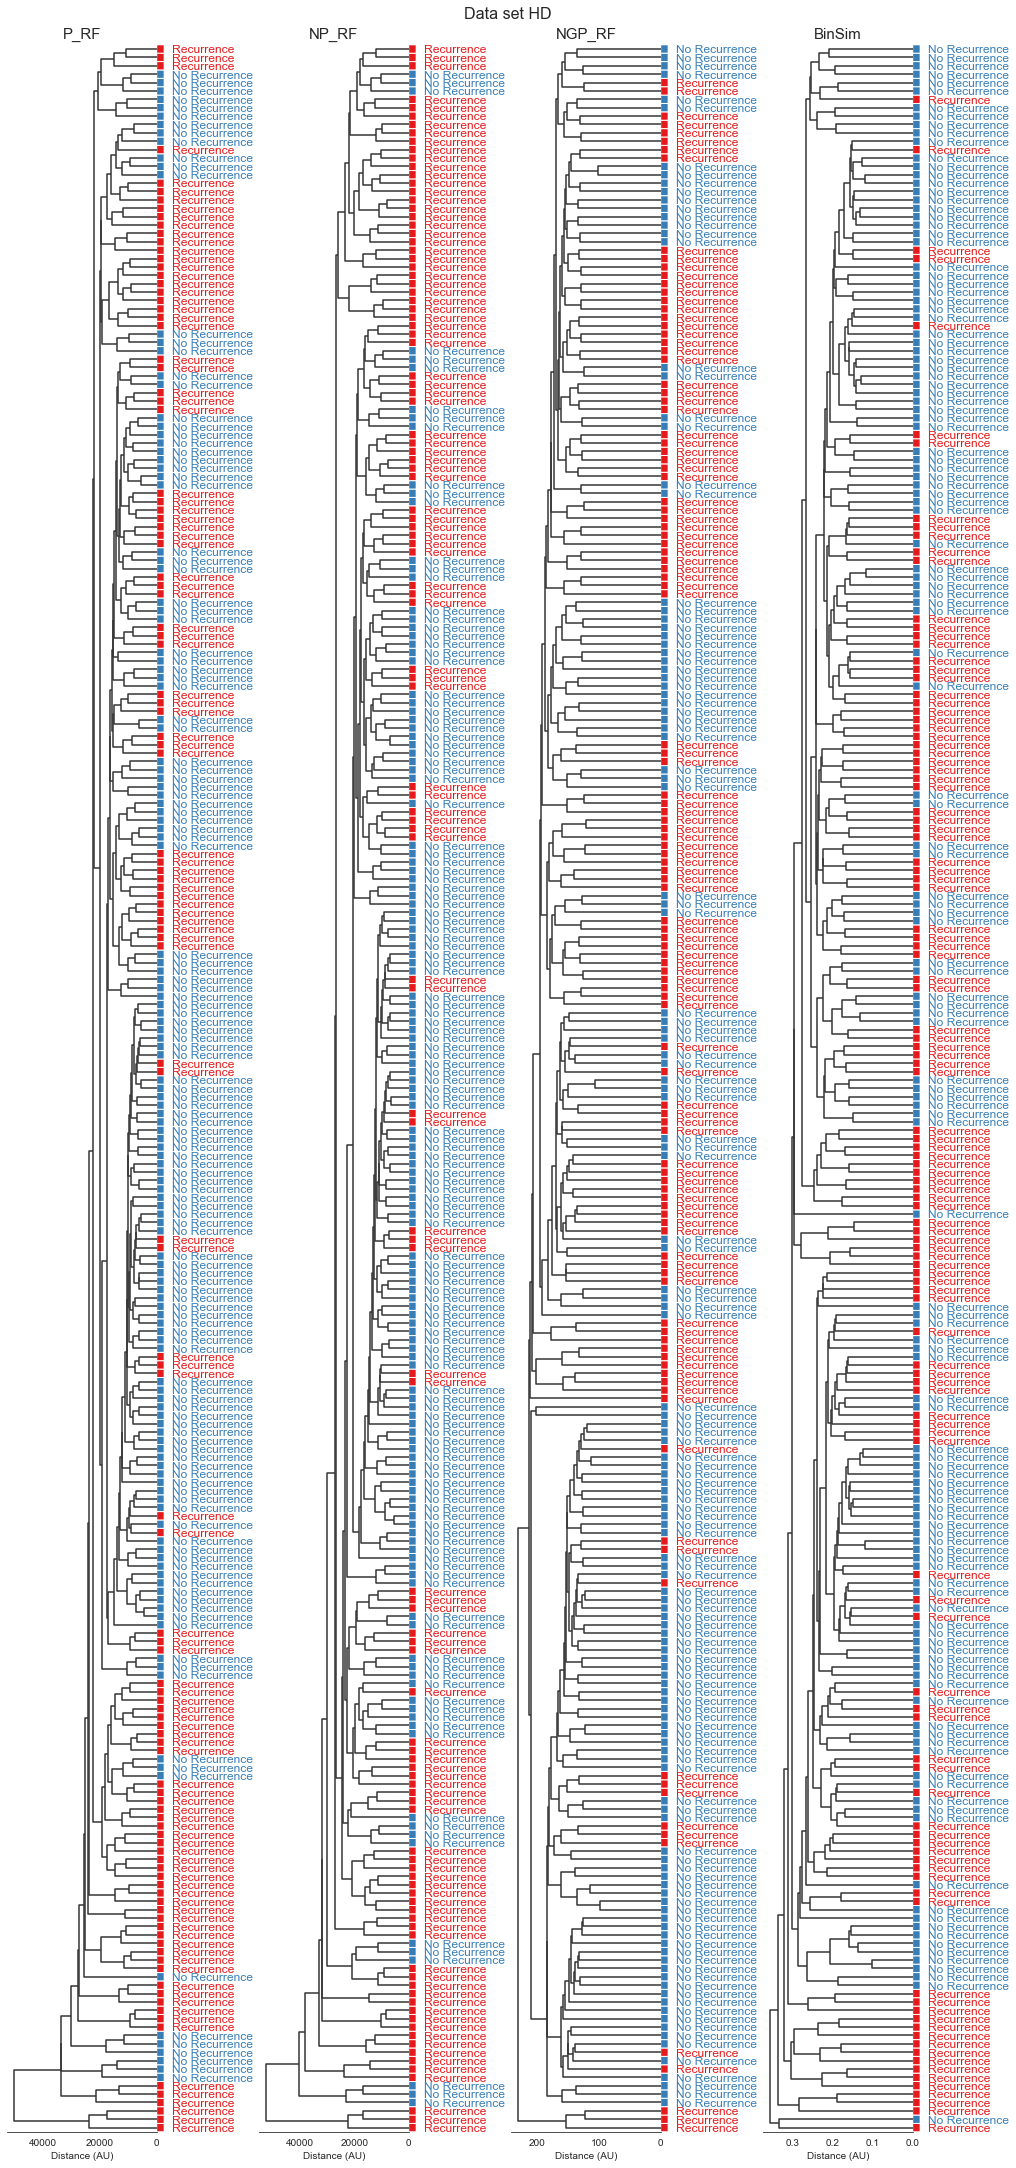

In [52]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 30), constrained_layout=True)
    
    name = 'HD'
      
    for treatment, ax in zip(('P_RF', 'NP_RF', 'NGP_RF', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f'Data set {datasets[name]["name"]}', fontsize=16)
    plt.show()

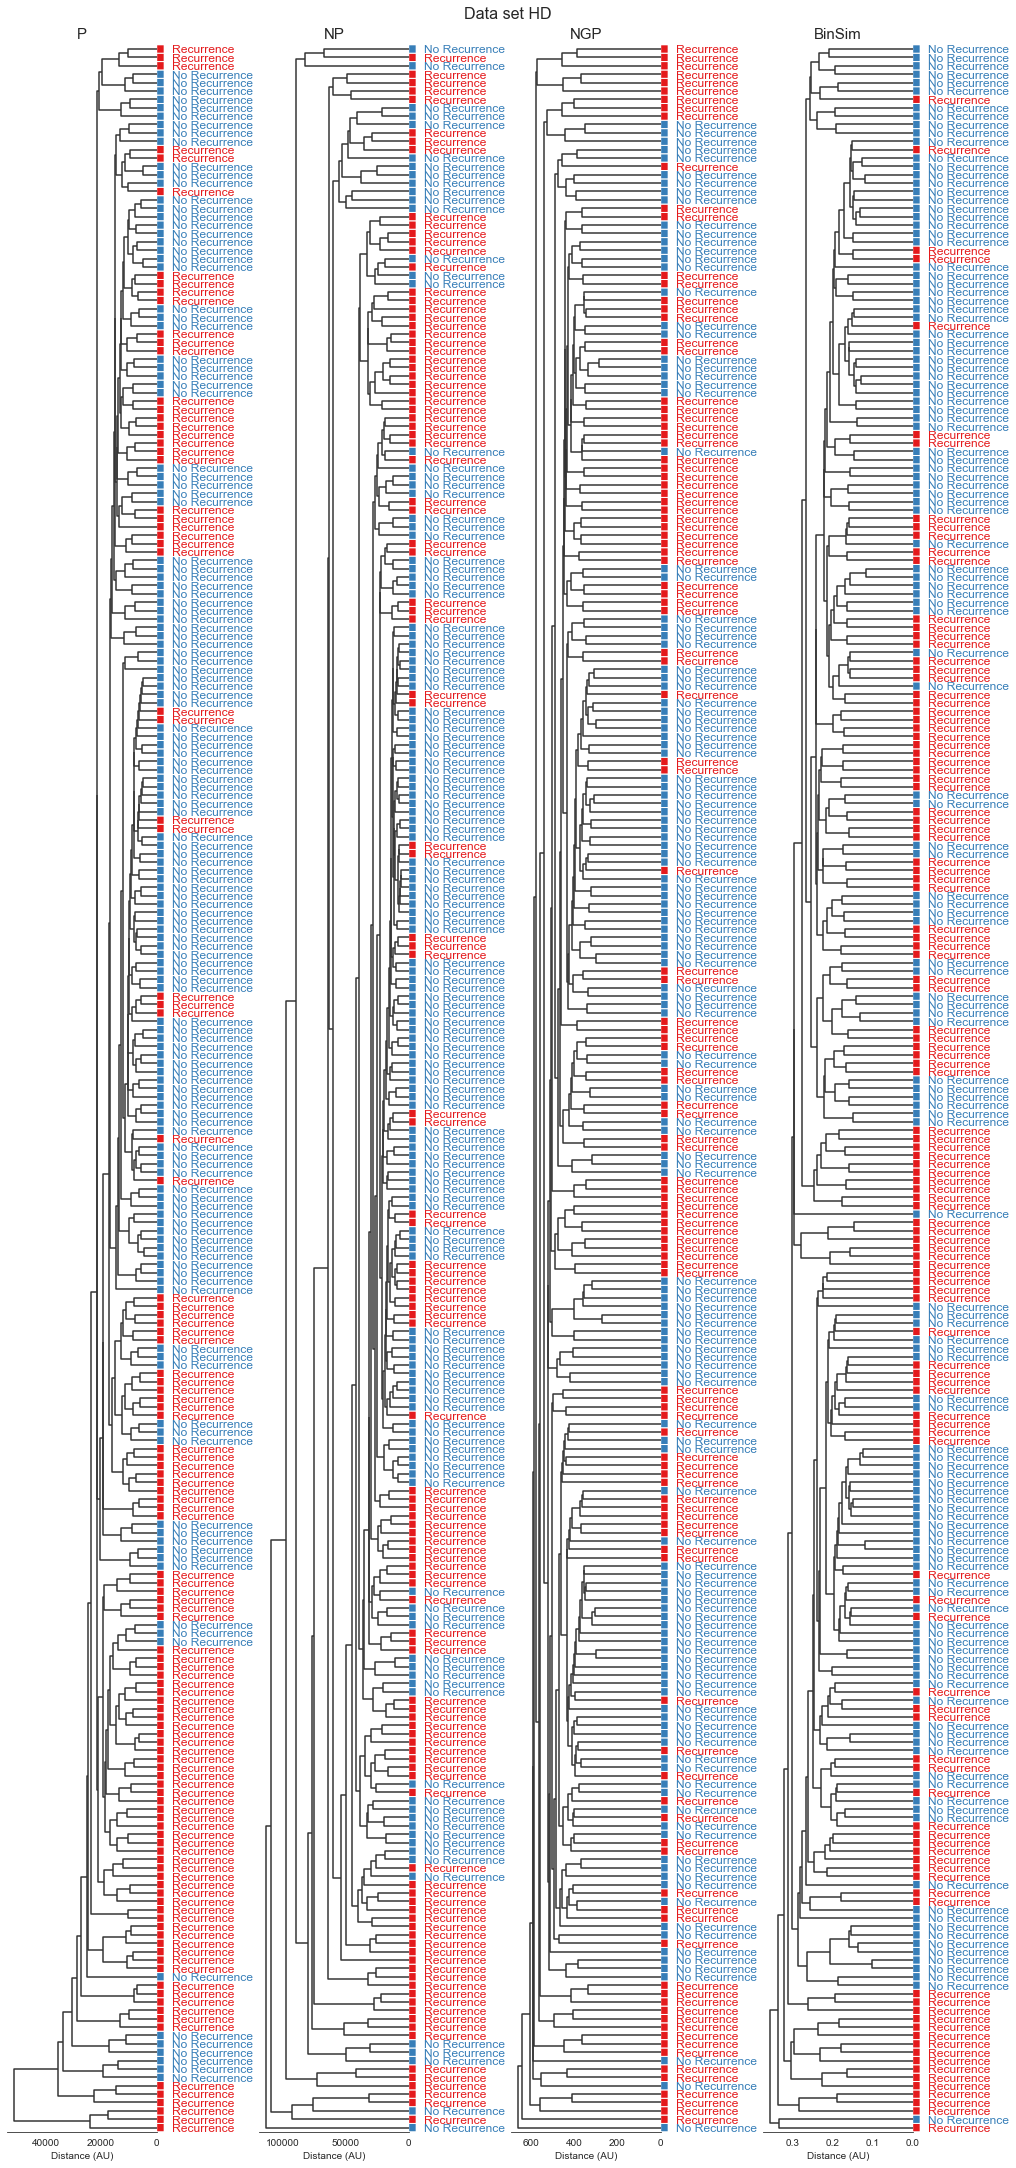

In [53]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 30), constrained_layout=True)
    
    name = 'HD'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f'Data set {datasets[name]["name"]}', fontsize=16)
    plt.show()

In [54]:
def compute_clustering_metrics(res_dict, labels):
    """Fill dict with clustering performance metrics."""
    
    discrim = ma.dist_discrim(res_dict['Z'], labels, # all samples have the same order
                              method = 'average')
    res_dict['Average discrim dist'] = discrim[0]
    correct = np.array(list(discrim[1].values()))
    
    classes = pd.unique(labels)
    res_dict['% correct clustering'] = (100/len(classes)) * len(correct[correct>0])

    # Correct First Cluster Percentage
    res_dict['% correct 1st clustering'] = 100 * ma.correct_1stcluster_fraction(res_dict['Z'],labels)

In [55]:
HCA_performance = []
for name, dataset in datasets.items():
    for treatment in ('P', 'NP', 'NGP', 'P_RF', 'NP_RF', 'NGP_RF', 'BinSim'):
        compute_clustering_metrics(HCA_all[name][treatment], datasets[name]['target'])
        perform = {'dataset': name, 'treatment': treatment,
                   'Discrimination Distance': HCA_all[name][treatment]['Average discrim dist'],
                   '% correct clusters': HCA_all[name][treatment]['% correct clustering'],
                   '% correct 1st clustering': HCA_all[name][treatment]['% correct 1st clustering']}
        HCA_performance.append(perform)
        
HCA_performance = pd.DataFrame(HCA_performance)
cv_dsnames = {name:datasets[name]['name'] for name in datasets}

HCA_performance2 = HCA_performance.assign(dataset = HCA_performance['dataset'].map(cv_dsnames))
HCA_performance2

,dataset,treatment,Discrimination Distance,% correct clusters,% correct 1st clustering
0,HD,P,0.0,0.0,93.574297
1,HD,NP,0.0,0.0,88.755020
2,HD,NGP,0.0,0.0,80.722892
3,HD,P_RF,0.0,0.0,95.180723
4,HD,NP_RF,0.0,0.0,93.975904
5,HD,NGP_RF,0.0,0.0,91.566265
6,HD,BinSim,0.0,0.0,81.526104


## Supervised methods

In [56]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

### ROC curves

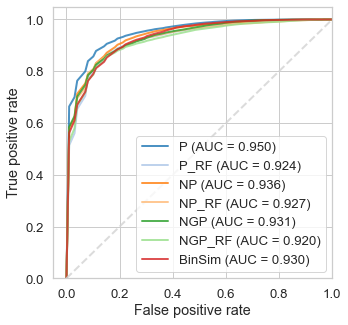

In [57]:
np.random.seed(16)
name = 'HD'
pos_label = 'Recurrence'
dataset = datasets[name]
y = dataset['target']
resROC = {}

p7 = sns.color_palette('tab20', 7)
treatments = ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim')
            
for treatment in treatments:
    df = dataset[treatment]
    res = ma.RF_ROC_cv(df, y, pos_label, n_fold=5, n_trees=20, n_iter=20)
    resROC[treatment] = res

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(5,5))
        for treatment, color in zip(resROC, p7):
            res = resROC[treatment]
            mean_fpr = res['average fpr']
            mean_tpr = res['average tpr']
            mean_auc = res['mean AUC']
            ax.plot(mean_fpr, mean_tpr, color=color,
                   label=f'{treatment} (AUC = {mean_auc:.3f})',
                   lw=2, alpha=0.8)
        
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
        ax.legend()
        ax.set_xlim(None,1)
        ax.set_ylim(0,None)
        ax.set(xlabel='False positive rate', ylabel='True positive rate', title='')
              # title="Random forest ROC curves for Vitis types data set")
        plt.show()
        f.savefig('paperimages/ROC_HD.pdf', dpi=200)
        f.savefig('paperimages/ROC_HD.png', dpi=600)

### Optimization of Random Forests

In [59]:
GENERATE = False
if GENERATE:
    # NOTE: for debugging
    top_tree_in_grid=200
    # otherwise
    #top_tree_in_grid=200

    # Vector with values for the parameter n_estimators
    # Models will be built from 10 to top_tree_in_grid trees in 5 tree intervals
    values = {'n_estimators': range(10,top_tree_in_grid,5)}

    rf = skensemble.RandomForestClassifier(n_estimators=200)
    clf = GridSearchCV(rf, values, cv=5)

    # For each dataset, build  Random Forest models with the different number of trees
    # and store the predictive accuracy (estimated by k-fold cross-validation)

    RF_optim = {}
    for name, dataset in datasets.items():
        for treatment in ('P', 'NP', 'NGP', 'P_RF', 'NP_RF', 'NGP_RF', 'BinSim'):
            print('Fitting to', dataset['name'], 'pre-treatment', treatment, '...', end=' ')
            rfname = name + ' ' + treatment
            RF_optim[rfname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}

            clf2use = clf
            clf2use.fit(dataset[treatment], dataset['target'])
            
            RF_optim[rfname]['scores'] = list(clf2use.cv_results_['mean_test_score'])
            RF_optim[rfname]['n_trees'] = list(clf2use.cv_results_['param_n_estimators'])

            print('Done!')
    #print('writing results to file')
    #path = Path.cwd() / 'paperimages' / 'RF_optim_HD.json'
    #print(path.name)
    #with open(path, "w", encoding='utf8') as write_file:
        #json.dump(RF_optim, write_file)

Fitting to HD pre-treatment P ... Done!
Fitting to HD pre-treatment NP ... Done!
Fitting to HD pre-treatment NGP ... Done!
Fitting to HD pre-treatment P_RF ... Done!
Fitting to HD pre-treatment NP_RF ... Done!
Fitting to HD pre-treatment NGP_RF ... Done!
Fitting to HD pre-treatment BinSim ... Done!


In [62]:
#path = Path.cwd() / 'paperimages' / 'RF_optim_HD.json'
#with open(path, "r", encoding='utf8') as read_file:
#    RF_optim = json.load(read_file)

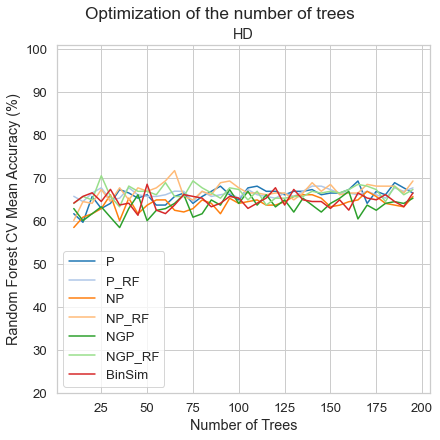

In [61]:
# Plotting the results and adjusting parameters of the plot

def plot_RF_otimization_ntrees(RF_optim, dskey, ax=None, ylabel='', title='', ylim=(20,101)):
    p7 = sns.color_palette('tab20', 7)
    to_plot = [optim for key, optim in RF_optim.items() if optim['dskey'] == dskey]
    treatments = ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim')
    if ax is None:
        ax = plt.gca()
    for treatment, color in zip(treatments, p7):
        for optim in to_plot:
            if optim['treatment'] == treatment:
                break
        ax.plot(optim['n_trees'], [s*100 for s in optim['scores']], label=treatment, color=color)
    ax.set(ylabel=ylabel, xlabel='Number of Trees', ylim=ylim, title=title)
    ax.legend()

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(6,6), constrained_layout=True)
        dskey = 'HD'
       
        plot_RF_otimization_ntrees(RF_optim, dskey, ax=ax,
                                   ylabel='Random Forest CV Mean Accuracy (%)',
                                   title=datasets[dskey]["name"])

        f.suptitle('Optimization of the number of trees')

        plt.show()

100 trees for RF

In [62]:
GENERATE = False
if GENERATE:
    # NOTE: for debugging
    iter_num=20
    # otherwise
    #iter_num=100

    RF_all = {}

    # Application of the Random Forests for each differently-treated dataset
    for name, dataset in datasets.items():
        for treatment in ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim'):
            print(f'Fitting random forest for {name} with treatment {treatment}', end=' ...')
            rfname = name + ' ' + treatment
            RF_all[rfname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            n_fold = 5 #if (name in ['vitis_types', 'HD']) else 3

            fit = ma.RF_model_CV(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=200)
            RF_all[rfname].update(fit)

            print(f'done')    
    fname = 'paperimages/RF_all_HD.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(RF_all, write_file)

Fitting random forest for HD with treatment P ...done
Fitting random forest for HD with treatment P_RF ...done
Fitting random forest for HD with treatment NP ...done
Fitting random forest for HD with treatment NP_RF ...done
Fitting random forest for HD with treatment NGP ...done
Fitting random forest for HD with treatment NGP_RF ...done
Fitting random forest for HD with treatment BinSim ...done


In [58]:
fname = 'paperimages/RF_all_HD.json'
with open(fname, "r", encoding='utf8') as read_file:
    RF_all = json.load(read_file)

In [59]:
# Accuracy across the iterations
accuracies = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracies

,HD P,HD P_RF,HD NP,HD NP_RF,HD NGP,HD NGP_RF,HD BinSim
0,0.903429,0.883918,0.895755,0.883755,0.899918,0.879673,0.883265
1,0.915837,0.899510,0.907755,0.879020,0.895837,0.871347,0.895673
2,0.903592,0.871592,0.915102,0.883429,0.899755,0.863510,0.899755
3,0.871755,0.879673,0.879592,0.879265,0.903755,0.891429,0.899592
4,0.911592,0.895347,0.903510,0.875429,0.867429,0.899673,0.903592
5,0.911837,0.899510,0.911837,0.891755,0.887265,0.883429,0.891755
6,0.915837,0.899592,0.907673,0.883429,0.903755,0.907510,0.891265
7,0.919918,0.883347,0.895755,0.895429,0.883020,0.871837,0.899429
8,0.899673,0.895510,0.891265,0.879592,0.915592,0.891184,0.919510
9,0.911755,0.879265,0.883429,0.879510,0.895673,0.887673,0.907755


In [60]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
HD P,0.908278,0.012447,HD,P
HD P_RF,0.884180,0.011824,HD,P_RF
HD NP,0.900576,0.009881,HD,NP
HD NP_RF,0.885678,0.006909,HD,NP_RF
HD NGP,0.893241,0.013686,HD,NGP
HD NGP_RF,0.883731,0.013999,HD,NGP_RF
HD BinSim,0.897347,0.010343,HD,BinSim


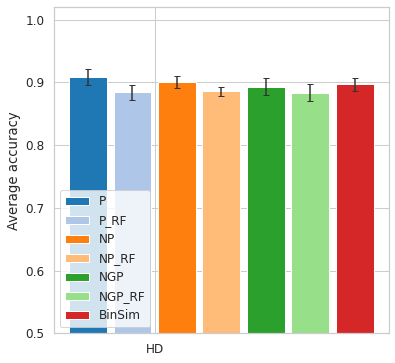

In [61]:
p7 = sns.color_palette('tab20', 7)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.1):
        f, ax = plt.subplots(1, 1, figsize=(6, 6))
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.17  # the width of the bars
        for i, treatment in enumerate(('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF','BinSim')):
            acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
            offset = - 0.3 + i * 0.2
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p7[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.5,1.02))
        #ax.text(-0.5, 0.95, 'A', weight='bold', fontsize=15)
        ax.legend(loc='lower left')#, bbox_to_anchor=(0.7, 1))
        #f.savefig('paperimages/RF_performance.pdf' , dpi=200)
        #f.savefig('paperimages/RF_performance.png' , dpi=600)

## PLS-DA

### Optimization of the number of components

In [67]:
%%capture --no-stdout
# line above supresses PLS warnings

GENERATE = False

if GENERATE:
    treatments = ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim')


    # NOTE: for debugging
    max_comp=20
    # otherwise
    #max_comp=50

    # Store Results
    PLS_optim = {}

    # Build and extract metrics from models build with different number of components by using the optim_PLS function.
    for name, dataset in datasets.items():
        for treatment in treatments:
            print(f'Fitting PLS-DA model for {name} with treatment {treatment}', end=' ...')
            plsdaname = name + ' ' + treatment
            PLS_optim[plsdaname] = {'dskey': name, 'dataset':dataset['name'], 'treatment':treatment}
            n_fold = 5
            optim = ma.optim_PLSDA_n_components(dataset[treatment], dataset['target'],
                                                max_comp=max_comp, n_fold=n_fold).CVscores
            PLS_optim[plsdaname]['CV_scores'] = optim
            print(f'done')
    fname = 'paperimages/PLSDA_optim_HD.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(PLS_optim, write_file)

Fitting PLS-DA model for HD with treatment P ...done
Fitting PLS-DA model for HD with treatment P_RF ...done
Fitting PLS-DA model for HD with treatment NP ...done
Fitting PLS-DA model for HD with treatment NP_RF ...done
Fitting PLS-DA model for HD with treatment NGP ...done
Fitting PLS-DA model for HD with treatment NGP_RF ...done
Fitting PLS-DA model for HD with treatment BinSim ...done


In [70]:
fname = 'paperimages/PLSDA_optim_HD.json'
with open(fname, "r", encoding='utf8') as read_file:
    PLS_optim = json.load(read_file)

In [68]:
treatments = ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim')
treat_colors = dict(zip(treatments, sns.color_palette('tab20', 7)))

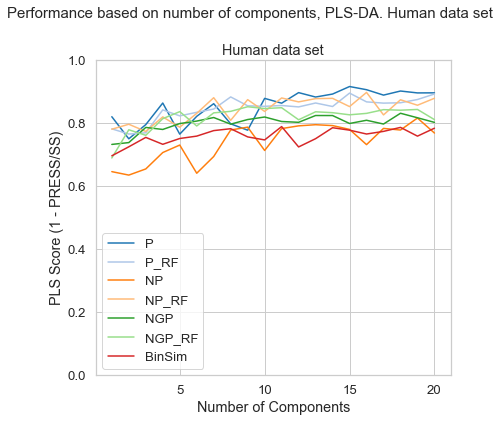

In [69]:
# Plotting the results and adjusting plot parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize = (6,6))
        plt.suptitle('Performance based on number of components, PLS-DA. Human data set', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'HD':

                ax.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'],
                         color = treat_colors[data['treatment']],
                         label=data['treatment'])
                ax.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Human data set')
                ax.legend()
                ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.show()

15 components chosen

In [70]:
%%capture --no-stdout
GENERATE = False
if GENERATE:
    PLSDA_all = {}

    iter_num=10

    # For each differently-treated dataset, fit PLS-DA models on n randomly sampled folds (for stratified cross-validation)
    for name, dataset in datasets.items():
        for treatment in ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim'):
            print(f'Fitting a PLS-DA model to {name} with treatment {treatment}', end=' ...')
            plsdaname = name + ' ' + treatment
            PLSDA_all[plsdaname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
            n_comp = 15
            n_fold = 5
            fit = ma.PLSDA_model_CV(dataset[treatment], dataset['target'],
                                    n_comp=n_comp, n_fold=n_fold,
                                    iter_num=iter_num,
                                    feat_type='VIP')
            PLSDA_all[plsdaname].update(fit)
            print(f'done')     

    fname = 'paperimages/PLSDA_all_HD.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(PLSDA_all, write_file)

Fitting a PLS-DA model to HD with treatment P ...done
Fitting a PLS-DA model to HD with treatment P_RF ...done
Fitting a PLS-DA model to HD with treatment NP ...done
Fitting a PLS-DA model to HD with treatment NP_RF ...done
Fitting a PLS-DA model to HD with treatment NGP ...done
Fitting a PLS-DA model to HD with treatment NGP_RF ...done
Fitting a PLS-DA model to HD with treatment BinSim ...done


In [62]:
# Accuracy across iterations
fname = 'paperimages/PLSDA_all_HD.json'
with open(fname, "r", encoding='utf8') as read_file:
    PLSDA_all = json.load(read_file)

accuracies = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracies

,HD P,HD P_RF,HD NP,HD NP_RF,HD NGP,HD NGP_RF,HD BinSim
0,0.975904,0.979920,0.907631,0.995984,0.963855,0.967871,0.971888
1,0.983936,0.975904,0.923695,0.987952,0.971888,0.987952,0.983936
2,0.971888,0.983936,0.939759,0.963855,0.975904,0.983936,0.967871
3,0.987952,0.975904,0.955823,0.979920,0.987952,0.983936,0.971888
4,0.975904,0.991968,0.927711,0.963855,0.983936,0.979920,0.987952
5,0.963855,0.971888,0.919679,0.971888,0.987952,0.991968,0.987952
6,0.983936,0.955823,0.915663,0.959839,0.987952,0.975904,0.975904
7,0.987952,0.983936,0.927711,0.979920,0.975904,0.991968,0.959839
8,0.979920,0.979920,0.907631,0.975904,0.987952,0.967871,0.979920
9,0.987952,0.991968,0.923695,0.979920,0.991968,0.967871,0.963855


In [63]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all],
                                       treatment=[PLSDA_all[name]['treatment'] for name in PLSDA_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
HD P,0.979920,0.008032,HD,P
HD P_RF,0.979116,0.010507,HD,P_RF
HD NP,0.924900,0.014548,HD,NP
HD NP_RF,0.975904,0.011359,HD,NP_RF
HD NGP,0.981526,0.009119,HD,NGP
HD NGP_RF,0.979920,0.009653,HD,NGP_RF
HD BinSim,0.975100,0.009801,HD,BinSim


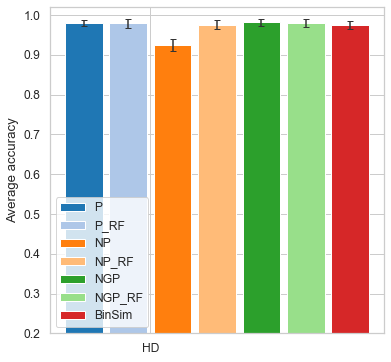

In [64]:
p7 = sns.color_palette('tab20', 7)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.1):
        f, ax = plt.subplots(1, 1, figsize=(6, 6))
        x = np.arange(len(datasets))  # the label locations
        labels = [datasets[name]['name'] for name in datasets]
        width = 0.17  # the width of the bars
        for i, treatment in enumerate(('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim')):
            acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
            offset = - 0.3 + i * 0.2
            rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p7[i])
            ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                        ls='none', ecolor='0.2', capsize=3)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.set(ylabel='Average accuracy', title='', ylim=(0.2,1.02))
        ax.legend(loc='lower left')
        plt.show()

## K-means Clustering Analysis

In [65]:
import sklearn.cluster as skclust
from sklearn.metrics import adjusted_rand_score

In [66]:
def perform_KMeans(dataset, treatment, iter_num=150, best_fraction=0.1):
    "Perform K-means Clustering Analysis and calculate discrimination evaluation metrics."
    
    sample_labels = datasets[dataset]['target']
    n_classes = len(pd.unique(sample_labels))
    
    df = datasets[dataset][treatment]
    
    discrim = ma.Kmeans_discrim(df, sample_labels,
                                method='average', 
                                iter_num=iter_num,
                                best_fraction=best_fraction)

    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    
    for j in discrim:
        global_disc_dist, disc_dists, rand_index, SSE = discrim[j]
        
        # Average of discrimination distances
        average.append(global_disc_dist) 
        
        # Correct Clustering Percentages
        all_correct = np.array(list(disc_dists.values()))
        correct.append(len(all_correct[all_correct>0]))
        
        # Adjusted Rand Index
        rand.append(rand_index) 
    
    return{'dataset': dataset,
           'treatment': treatment,
           'Discrimination Distance': np.median(average),
           '% correct clusters':np.median(correct)*100/n_classes,
           'Rand Index': np.median(rand)}

In [67]:
# NOTE: for debugging
iter_num=15
# otherwise
#iter_num=150

KMeans_all = []

dsname = 'HD'
for treatment in ('P', 'NP', 'NGP', 'P_RF', 'NP_RF', 'NGP_RF', 'BinSim'):
    print(f'performing KMeans on {dsname} with treatment {treatment}' , end=' ...')
    KMeans_all.append(perform_KMeans(dsname, treatment, iter_num=iter_num))
    print('done!')        

performing KMeans on HD with treatment P ...done!
performing KMeans on HD with treatment NP ...done!
performing KMeans on HD with treatment NGP ...done!
performing KMeans on HD with treatment P_RF ...done!
performing KMeans on HD with treatment NP_RF ...done!
performing KMeans on HD with treatment NGP_RF ...done!
performing KMeans on HD with treatment BinSim ...done!


In [68]:
KMeans_all = pd.DataFrame(KMeans_all)

cv_dsnames = {name:datasets[name]['name'] for name in datasets}
KMeans_all2 = KMeans_all.assign(dataset = KMeans_all['dataset'].map(cv_dsnames))
KMeans_all2

,dataset,treatment,Discrimination Distance,% correct clusters,Rand Index
0,HD,P,0.0,0.0,0.154608
1,HD,NP,0.0,0.0,0.059987
2,HD,NGP,0.0,0.0,-0.004088
3,HD,P_RF,0.0,0.0,0.154608
4,HD,NP_RF,0.0,0.0,0.129957
5,HD,NGP_RF,0.0,0.0,0.157661
6,HD,BinSim,0.0,0.0,-0.004088


## Supervised Statistical Analysis - Permutation Tests

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5-fold cross-validation in `vitis_types`).

## Permutation Tests (Very Slow)

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random k-fold cross-validation is performed on the original dataset (to serve as a comparation point) and on 500 permutations of datasets with labels randomly shuffled around. The models are evaluated by their predictive accuracies. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random k-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala and Garriga, 2010).

Ojala M, Garriga GC. Permutation Tests for Studying Classifier Performance. In: 2009 Ninth IEEE International Conference on Data Mining. ; 2009:908-913. doi:10.1109/ICDM.2009.108

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

### Permutation Tests - Random Forests

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [69]:
# json for persistence
import json
from time import perf_counter

Use `GENERATE = True` to perform permutation tests and persist results in json

In [70]:
GENERATE = True #False

In [ ]:
if GENERATE:
    iter_num=500 # number of permutations


    permuts_RF = []

    to_permute = [name for name in datasets]
    for name in to_permute:
        for treatment in ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim'):
            dataset = datasets[name]
            print(f'{iter_num} permutations (Random Forest) for {name} with treatment {treatment}', end=' ...')
            n_fold = 5
            start = perf_counter()
            permutations = ma.permutation_RF(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}       
            permuts_RF.append(res)
            end = perf_counter()
            pvalue = permutations[2]
            print(f'Done! took {(end - start):.3f} s, p-value = {pvalue:.4f}')

In [72]:
    
    # Store in json file
    fname = 'paperimages/permuts_rf_hd.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_RF, write_file)

### Permutation Tests - PLS-DA

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [73]:
%%capture --no-stdout
if GENERATE:
    iter_num=500

    permuts_PLSDA = []

    to_permute = [name for name in datasets]
    for name in to_permute:
        for treatment in ('P', 'P_RF', 'NP', 'NP_RF', 'NGP', 'NGP_RF', 'BinSim'):
            dataset = datasets[name]
            print(f'Permutation test (PLS-DA) for {name} with treatment {treatment}', end=' ...')
            n_comp = 15
            n_fold = 5
            start = perf_counter()
            permutations = ma.permutation_PLSDA(dataset[treatment], dataset['target'], n_comp=11,
                                                iter_num=iter_num, n_fold=n_fold)
            res = {'dataset': name, 'treatment': treatment,
                   'non_permuted_CV': permutations[0],
                   'permutations': permutations[1],
                   'p-value': permutations[2]}
            permuts_PLSDA.append(res)
            end = perf_counter()
            pvalue = permutations[2]
            print(f'Done! took {(end - start):.3f} s, p-value = {pvalue:.4f}')
            
    # Store in json file
    fname = 'paperimages/permuts_plsda_hd.json'
    with open(fname, "w", encoding='utf8') as write_file:
        json.dump(permuts_PLSDA, write_file)

Permutation test (PLS-DA) for HD with treatment P ...Done! took 858.170 s, p-value = 0.0020
Permutation test (PLS-DA) for HD with treatment P_RF ...Done! took 865.247 s, p-value = 0.0020
Permutation test (PLS-DA) for HD with treatment NP ...Done! took 859.857 s, p-value = 0.0020
Permutation test (PLS-DA) for HD with treatment NP_RF ...Done! took 859.855 s, p-value = 0.0020
Permutation test (PLS-DA) for HD with treatment NGP ...Done! took 857.719 s, p-value = 0.0020
Permutation test (PLS-DA) for HD with treatment NGP_RF ...Done! took 860.013 s, p-value = 0.0020
Permutation test (PLS-DA) for HD with treatment BinSim ...Done! took 864.704 s, p-value = 0.0020


In [74]:
# Get data from json file - random forests
fname = 'paperimages/permuts_rf_hd.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_RF = json.load(read_file)

for p in permuts_RF:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

HD                  P          0.00200
HD                  P_RF       0.00200
HD                  NP         0.00200
HD                  NP_RF      0.00200
HD                  NGP        0.00200
HD                  NGP_RF     0.00200
HD                  BinSim     0.00200


In [75]:
# Get data from json file - PLS-DA
fname = 'paperimages/permuts_plsda_hd.json'
with open(fname, "r", encoding='utf8') as read_file:
    permuts_PLSDA = json.load(read_file)

for p in permuts_PLSDA:
    print(f"{p['dataset']:<20}{p['treatment']:<8}{p['p-value']:10.5f}")

HD                  P          0.00200
HD                  P_RF       0.00200
HD                  NP         0.00200
HD                  NP_RF      0.00200
HD                  NGP        0.00200
HD                  NGP_RF     0.00200
HD                  BinSim     0.00200
